NOTE: This script is made only to speed up the creation of more augmented versions of the dataset. It requires that you have alredy run Augmentation.jpynb using the 'resize_only' parameter, then renamed the 'augmented_dataset' folder as 'augmented_dataset-resize_only'



In [ ]:
import os
import sys
import time

from google.colab import drive
drive.mount('/content/drive')

AUGMENTED_DATASET_FOLDER = '/content/drive/My Drive/Neural/augmented_dataset-resize_only/'
TRAINING_IMAGES_FOLDER = '/content/drive/My Drive/Neural/augmented_dataset-resize_only/training_images'
TRAINING_CSV = '/content/drive/My Drive/Neural/augmented_dataset-resize_only/training_labels.csv'

OUTPUT_DATASET = '/content/drive/My Drive/Neural/output_dataset/'
OUTPUT_TRAINING_IMAGES_FOLDER = '/content/drive/My Drive/Neural/output_dataset/training_images'


print(AUGMENTED_DATASET_FOLDER)
print(TRAINING_IMAGES_FOLDER)
print(TRAINING_CSV)

print(OUTPUT_DATASET)
print(OUTPUT_TRAINING_IMAGES_FOLDER)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Neural/augmented_dataset-resize_only/
/content/drive/My Drive/Neural/augmented_dataset-resize_only/training_images
/content/drive/My Drive/Neural/augmented_dataset-resize_only/training_labels.csv
/content/drive/My Drive/Neural/output_dataset/
/content/drive/My Drive/Neural/output_dataset/training_images


## Custom Dataset definition

In [ ]:
import pandas as pd
import numpy as np

labels_csv = pd.read_csv(TRAINING_CSV)
labels_csv.sample(10)

,index,patientId,x,y,x_max,y_max,Target
7849,7849,619f82fc-2d14-469f-8d00-4d7f2db77c1a_0,116.5,122.5,184.5,332.5,1
15566,15566,a569ba29-63e9-4a28-a0f5-7fff04b72484_0,0.0,0.0,0.0,0.0,0
21274,21274,d47e4af8-01b9-44fc-b53c-35f3dbcfba85_0,0.0,0.0,0.0,0.0,0
8570,8570,67df081f-50f8-4ff4-89e9-4959f843c10d_0,0.0,0.0,0.0,0.0,0
7848,7848,619d0a04-2c4a-4cbf-b8bf-76bc5c685835_0,0.0,0.0,0.0,0.0,0
26372,26372,0fff88da-4b97-4a84-8cac-67f093cbbd93_0,0.0,0.0,0.0,0.0,0
18157,18157,b94ef581-b098-4fa2-909f-96f22d6fd446_0,0.0,0.0,0.0,0.0,0
10851,10851,7bca5ce8-2b0c-4fcb-95b5-f43470092618_0,68.0,131.5,169.5,274.0,1
12090,12090,8721de5e-f6c8-4af0-a695-356e969f4687_0,0.0,0.0,0.0,0.0,0
2196,2196,31eb47ce-891a-44f3-9031-96d8952b487c_0,0.0,0.0,0.0,0.0,0


In [ ]:
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def parse_one_annot(box_coord, filename):
  boxes_array = box_coord[box_coord["patientId"] == filename][["x", "y", "x_max", "y_max"]].values
  return boxes_array 

In [ ]:
class CXRimages(Dataset):
    def __init__(self, csv_file, images_dir, transform=None):
      self.path = images_dir
      self.annotations = csv_file
      self.transform = transform
      self.imgs = sorted(os.listdir(images_dir))


    def num_classes(self):
      return 3


    def __len__(self):
      return len(self.annotations)


    def __getitem__(self, idx):   #requires to define new indexes from 0
        patient_id = self.annotations['patientId'][idx]

        # load image
        img_path = os.path.join(self.path, patient_id )
        img=plt.imread(img_path) #.convert("RGB")

        # set bounding boxes
        box_list = parse_one_annot(self.annotations, patient_id)
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)

        # set the box labels depending on patient label
        if len(torch.nonzero(boxes)) > 0:
          labels = torch.ones((num_objs,), dtype=torch.int64)
        else:
          labels = torch.zeros((num_objs,), dtype=torch.int64)

        # extra information for standard torchvision format (not really neeeded here)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # set metadata
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["patient_id"] = patient_id 

        if self.transform is not None:
                img = self.transform(img)

        return img, target

Let's load the dataset using the custom loader

In [ ]:
train_dataset_aug = CXRimages(csv_file = labels_csv, images_dir = TRAINING_IMAGES_FOLDER, transform = None)
print(f'Samples in train set: {len(train_dataset_aug)} \n')

Samples in train set: 27239 



## Show sample images

Let's show an example of custom dataset object

In [ ]:
train_dataset_aug.__getitem__(3)

(array([[0, 3, 2, ..., 2, 2, 2],
        [0, 3, 3, ..., 3, 3, 3],
        [1, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 4, 4, ..., 6, 6, 6],
        [2, 5, 4, ..., 7, 7, 7],
        [0, 3, 1, ..., 2, 2, 2]], dtype=uint8),
 {'area': tensor([28992.]),
  'boxes': tensor([[281.0000,  76.0000, 409.0000, 302.5000]]),
  'image_id': tensor([3]),
  'iscrowd': tensor([0]),
  'labels': tensor([1]),
  'patient_id': '00436515-870c-4b36-a041-de91049b9ab4_0'})

Let's plot some example images

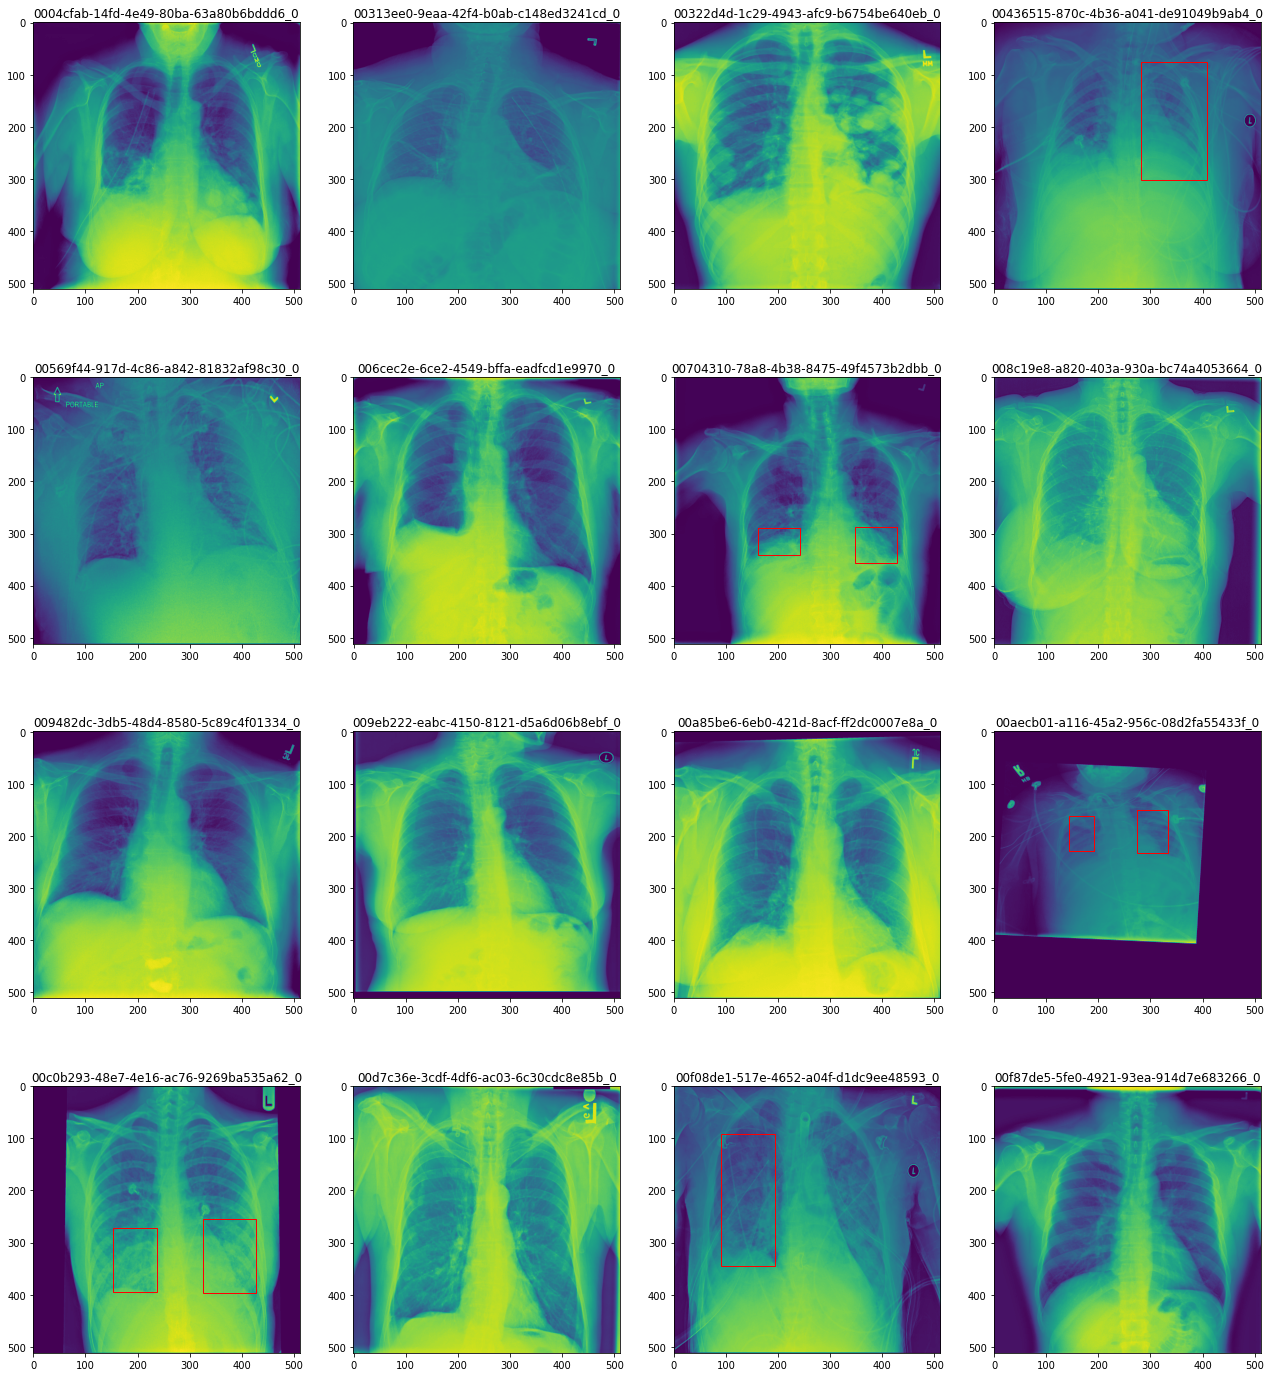

In [ ]:
def print_samples_with_boxes(dataset):

  # initalize variables for loop
  grid, gridx = plt.subplots(4,4, figsize=(22,25))
  old_patient_id = -1     # impossible value for a patient_id
  dataframe_counter = -1  # index refering to position in dataframe
  img_index = 0           # index refering to image position inside grid
  

  while img_index < 16:
    dataframe_counter += 1 

    # retrieve data
    data = dataset.__getitem__(dataframe_counter)
    patient_id = data[1]['patient_id']

    # check if it is new image, otherwise just skip
    if patient_id == old_patient_id:
      continue

    # other data needed
    image = data[0]
    boxes = data[1]['boxes']
    target = data[1]['labels'][0].item()

    # initialize image plot
    img = np.squeeze(image)
    gridx[img_index//4, img_index%4].set_title(patient_id)
    gridx[img_index//4, img_index%4].imshow(img)

    # bounding boxes (might be more for one pic)
    for j in range(len(boxes)):
      x1 = boxes[j][0]
      y1 = boxes[j][1]
      x2 = boxes[j][2]
      y2 = boxes[j][3]
      gridx[img_index//4, img_index%4].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none'))

    # this is needed to avoid showing duplicates in case of more bounding boxes
    old_patient_id = patient_id
    img_index += 1

  plt.show()


print_samples_with_boxes(train_dataset_aug)

## Training set augmentation

Let's set the number of augmented copies and the type of augmentation. For the type select between:
- 'light'
- 'heavy'
- 'heavy_with_rotations'

In [ ]:
augmentation_type = 'light'

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [ ]:
# no resize here

def augmentation_level(level):
  if level == 'light':
    list_augmentations = [
      iaa.Affine(
        scale=1.1, 
        shear=(2.5,2.5), 
        rotate=(-5, 5), 
      ),    
    ]
    num_augmentations = 1
    
  elif level == 'heavy': #no rotation included
    list_augmentations = [
      iaa.Affine(
        scale=1.15, 
        shear=(4.0,4.0),
      ),   
      iaa.Fliplr(0.2), # horizontally flip 20% of the images
      iaa.Sometimes(0.1, iaa.CoarseSaltAndPepper(p=(0.01, 0.01), size_percent=(0.1, 0.2))),
      iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 2.0))),
      iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0, 0.04 * 255))),            
           
    ]
    num_augmentations = 2

  elif level == 'heavy_with_rotations':
    list_augmentations = [
      iaa.Affine(
        scale=1.15, 
        shear=(4.0,4.0),
        rotate=(-6, 6), 
      ),   
      iaa.Fliplr(0.2), # horizontally flip 20% of the images
      iaa.Sometimes(0.1, iaa.CoarseSaltAndPepper(p=(0.01, 0.01), size_percent=(0.1, 0.2))),
      iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 2.0))),
      iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0, 0.04 * 255))),            
    ]
    num_augmentations = 2

  return list_augmentations, num_augmentations


list_augmentations, num_augmentations = augmentation_level(augmentation_type)
seq_training = iaa.Sequential(list_augmentations)

Perform full training set augmentation and save 

In [ ]:
print(f'Augmentation ({augmentation_type}) training set.... ', end='')
start = time.time()

# initialize output dataframe
output_dataframe = pd.DataFrame(columns=['index', 'patientId',	'x', 'y', 'x_max', 'y_max', 'Target'])

# initalize variables for loop
old_patient_id = -1     # impossible value for a patient_id
output_index = -1       # counter for the output dataframe
dataframe_counter = 0   # counter for the input dataframe
dataset_images = len(train_dataset_aug)

while dataframe_counter < dataset_images:
  # retrieve data
  data = train_dataset_aug.__getitem__(dataframe_counter)
  patient_id = data[1]['patient_id']

  # check if it is new image, otherwise just skip
  if patient_id == old_patient_id:
    dataframe_counter += 1 
    continue

  # other data needed
  image = data[0]
  boxes = data[1]['boxes']
  target = data[1]['labels'][0].item()
  
  # bounding boxes encoding for imgaug sequential
  list_boxes = []
  for j in range(len(boxes)):
    list_boxes.append(BoundingBox(x1=boxes[j][0].item(), x2=boxes[j][2].item(), y1=boxes[j][1].item(), y2=boxes[j][3].item()))
  bbs = BoundingBoxesOnImage(list_boxes, shape=image.shape)

  # make a new augmented copy for each value in num_augmentations
  for aug_num in range(num_augmentations):
    # perform augmentation 
    image_aug, bbs_aug = seq_training(image=image, bounding_boxes=bbs)

    # save augmented image
    augmented_name = patient_id + '_' + str(aug_num)
    img = Image.fromarray(image_aug)
    image_path = os.path.join(OUTPUT_TRAINING_IMAGES_FOLDER, augmented_name)
    img.save(image_path, 'png') 

    # iterate through boxes only if target==1, otherwise just write 0 everywhere
    if target == 1:
      # extract augmented boxes
      for box in bbs_aug.bounding_boxes:
        output_index += 1
        x1 = box.x1
        y1 = box.y1
        x2 = box.x2
        y2 = box.y2   

        # save new row in dataframe
        output_dataframe = output_dataframe.append({'index': output_index, 'patientId': augmented_name,	
                                                    'x': x1, 'y':y1, 'x_max':x2, 'y_max': y2, 'Target': target},
                                                    ignore_index=True)
    else:
      output_index += 1
      # save new row in dataframe
      output_dataframe = output_dataframe.append({'index': output_index, 'patientId': augmented_name,	
                                                    'x': 0, 'y':0, 'x_max':0, 'y_max': 0, 'Target': target},
                                                    ignore_index=True)

  # this is needed to avoid image duplicates in case of more bounding boxes
  old_patient_id = patient_id 
  dataframe_counter += 1 

# save dataframe as CSV 
output_dataframe.to_csv(path_or_buf=OUTPUT_DATASET +'training_labels.csv', index=False)

end = time.time()
minutes = format((end - start)/60, '.2f')
print('done!')
print(f'Time required: {minutes} minutes')
print(f'validation_labels rows: {len(output_dataframe)}')

Augmentation (light) training set.... done!
Time required: 299.51 minutes
validation_labels rows: 27239
